In [1]:
import numpy as np
import pickle
import sklearn

# IMBD Reciews Classifier
* **Goal**: determine if a review is overall positive or negative
* Will use NLP
 * Use TF-IDF to represent reviews
 * Use the TF-IDF as higher-level features to classify
* Only care about good/bad

# 0. Unpack the given data

In [2]:
with open("word_list.pkl", mode="rb") as opened_file:
    vocab = pickle.load(opened_file)

In [3]:
with np.load("imdb_review_data.npz") as opened_archive:
    word_counts = opened_archive["word_counts"]
    ratings = opened_archive["ratings"]
    stop_indices = opened_archive["stop_indices"]

In [4]:
# vocab:
# int indices corresponding to str words they represent

print(len(vocab))
vocab[:10]

10543


['the', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this']

In [5]:
# word_counts:
# ndarray with rows representing reviews and columns representing words 
# entries signify how many total times a given word appears in a given review

N = word_counts.shape[0]
print(word_counts.shape)
word_counts[:5, :10]

(25000, 10543)


array([[ 9,  1,  4,  4,  6,  4,  2,  2,  4,  0],
       [ 7,  4,  2,  2,  0,  4,  1,  0,  2,  2],
       [ 4,  4,  4,  7,  2,  1,  1,  1,  0,  1],
       [10,  2,  2,  0,  3,  2,  4,  2,  0,  1],
       [13,  9,  6,  4,  2,  5, 10,  6,  0,  2]], dtype=int16)

In [6]:
# ratings:
# ndarray containing the ratings corresponding to each review

print(ratings.shape)
ratings[:5]

(25000,)


array([ 9,  7,  9, 10,  8])

In [7]:
# stop_indices:
# ndarray with indices of every word considered a stopword

print(stop_indices.shape)
stop_indices[:9]

(489,)


array([0, 1, 2, 3, 4, 5, 6, 7, 9])

# 1. Remove stop words

In [8]:
word_counts_deleted = np.delete(word_counts, stop_indices, axis=1)
del word_counts

In [9]:
vocab_deleted = np.delete(vocab, stop_indices)
del vocab

In [10]:
print(len(vocab_deleted))
vocab_deleted[:10]

10054


array(['i', 'movie', 'film', '!', '?', 'good', 'time', 'story', 'people',
       'bad'],
      dtype='<U17')

In [11]:
print(word_counts_deleted.shape)
word_counts_deleted[:5, :10]

(25000, 10054)


array([[4, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [2, 0, 0, 1, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 2, 0, 0, 4, 1, 0],
       [0, 0, 1, 0, 0, 0, 1, 2, 0, 0]], dtype=int16)

# 2. Compute TF-IDF representations

In [12]:
# convert from counts to probabilities in each article
tfs = word_counts_deleted/np.sum(word_counts_deleted, axis=1, keepdims=True)

In [13]:
# elements count towards n_f if they are nonzero
idfs = np.log10(N/np.count_nonzero(word_counts_deleted, axis=0))
del word_counts_deleted

In [14]:
print(tfs.shape)
print(np.sum(tfs, axis=1))
tfs[:4, :5]

(25000, 10054)
[ 1.  1.  1. ...,  1.  1.  1.]


array([[ 0.07407407,  0.        ,  0.        ,  0.01851852,  0.        ],
       [ 0.05263158,  0.        ,  0.        ,  0.02631579,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.01923077,  0.        ],
       [ 0.        ,  0.        ,  0.03030303,  0.03030303,  0.06060606]])

In [15]:
print(idfs.shape)
idfs[:5]

(10054,)


array([ 0.11375751,  0.21621072,  0.25661568,  0.46369413,  0.52947191])

In [16]:
tf_idfs = tfs * idfs
del tfs, idfs

In [17]:
print(tf_idfs.shape)
tf_idfs[:4, :5]

(25000, 10054)


array([[ 0.00842648,  0.        ,  0.        ,  0.00858693,  0.        ],
       [ 0.00598724,  0.        ,  0.        ,  0.01220248,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.00891719,  0.        ],
       [ 0.        ,  0.        ,  0.00777623,  0.01405134,  0.03208921]])

# 3. Discretize labels to only be good/bad

In [18]:
print(min(ratings), max(ratings))

1 10


In [19]:
# 1, 2, 3, 4, 5 -> bad [0]
# 6, 7, 8, 9, 10 -> good [1]
ratings_new = (ratings > 5).astype(int)
del ratings

In [20]:
print(ratings_new.shape)
ratings_new[:5]

(25000,)


array([1, 1, 1, 1, 1])

In [21]:
ratings_new[-5:]

array([0, 0, 0, 0, 0])

# 4. Jointly shuffle data

In [22]:
tf_idfs_shuffled, ratings_shuffled = sklearn.utils.shuffle(tf_idfs, ratings_new)
del tf_idfs, ratings_new

# 5. Split data into train/test

In [23]:
# 20K train
# 5K test
N_train = 20000
N_test = tf_idfs_shuffled.shape[0] - 20000
x_train_raw = tf_idfs_shuffled[:N_train]
x_test_raw = tf_idfs_shuffled[N_train:]
y_train = ratings_shuffled[:N_train]
y_test = ratings_shuffled[N_train:]
del tf_idfs_shuffled, ratings_shuffled

In [24]:
print(x_train_raw.shape, y_train.shape)
print(x_test_raw.shape, y_test.shape)

(20000, 10054) (20000,)
(5000, 10054) (5000,)


# 6. Normalize the data

In [25]:
# in a relisitc situation we can only compute the statistics of the training data
# thus, normalize both train and test based on train's mean and std

# statistics are computed along the entire matrix and not individual features,
# as that would nullify frequency and idf information

mean = np.mean(x_train_raw)
std = np.std(x_train_raw)

In [26]:
x_train = (x_train_raw-mean)/std
x_test = (x_test_raw-mean)/std
del x_train_raw, x_test_raw

In [27]:
print(x_train.shape)
print(x_test.shape)
print("Train: ", np.mean(x_train), ", ", np.std(x_train))
print("Test: ", np.mean(x_test), ", ", np.std(x_test))
x_train[:4, :5]

(20000, 10054)
(5000, 10054)
Train:  8.64204846314e-17 ,  1.0
Test:  -5.09641036701e-05 ,  1.00415657624


array([[ -0.06143273,   4.33359804,   2.54674922,   4.65144627,
         -0.06143273],
       [  0.9518704 ,  -0.06143273,   7.93894562,   2.00376144,
          2.29672157],
       [  0.7296548 ,  -0.06143273,   0.53341579,  16.06157436,
         -0.06143273],
       [  0.73665558,  -0.06143273,   4.43941223,   1.56513613,
         -0.06143273]])

# 7. Single layer classifier

In [28]:
from mynn.layers.dense import dense
from mynn.initializers.glorot_normal import glorot_normal

class Model:
    def __init__(self, inp, outp):
        """ Create a Model object and initialize its parameters
        
        Paramaters
        ----------
        None
        
        Returns
        -------
        None"""
        self.dense1 = dense(inp, outp, weight_initializer=glorot_normal)
    
    def __call__(self, x):
        """ Performs one forward pass with the model
        
        Parameters
        ----------
        x:      A batch of data to process
                Tensor shape (N, inp)
        
        Returns
        -------
        y_pred: The result of the forward pass
                Tensor shape (N, outp)"""
        return self.dense1(x)
    
    @property
    def parameters(self):
        """ Returns all of the trainable parameters of the network
        
        Parameters
        ----------
        None
        
        Returns
        -------
        params: combined tuple of all trainable parameters
                tuple(Tensor)"""
        return self.dense1.parameters

In [29]:
def accuracy(predictions, truth):
    """ Comapres prediction and truth index vectors and
    computes accuracy based on the number of matches
    
    Parameters
    ----------
    predctions: output of the network to use for comparison
                Tensor or ndarray shape (N, D)
    
    truth:      groundtruth index vectors to compare against
                ndarray shape (N,)
    
    Returns
    -------
    accuracy:   resulting accuracy between 0 and 1
                float"""
    if isinstance(predictions, mg.Tensor):
        predictions = predictions.data
    return np.mean(np.argmax(predictions, axis=1) == truth)

<IPython.core.display.Javascript object>


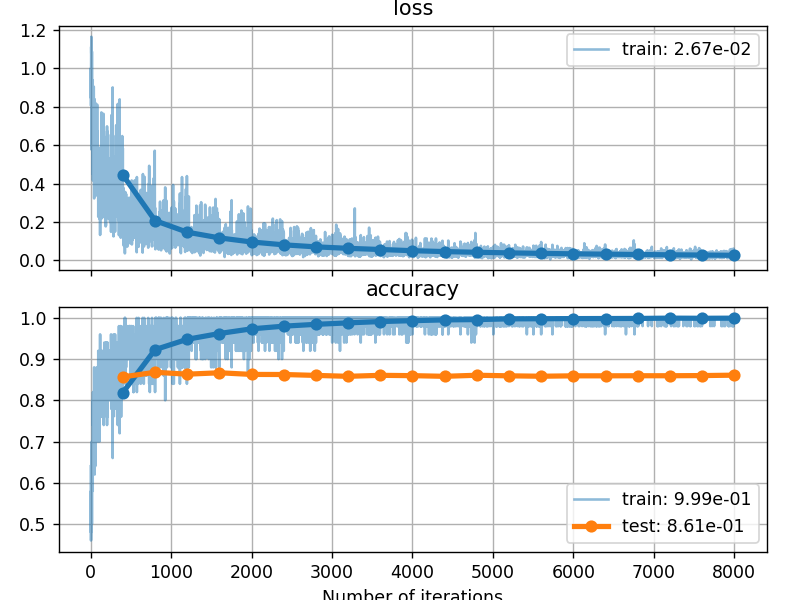

In [30]:
from mynn.optimizers.sgd import SGD
from mynn.losses.cross_entropy import softmax_cross_entropy
import mygrad as mg
import liveplot
%matplotlib notebook

# initialize stuff

model = Model(x_train.shape[1], 2)
optim = SGD(model.parameters, learning_rate=1e-2, momentum=0.9, weight_decay=1e-4)

plotter, fig, ax = liveplot.create_plot(metrics=["loss", "accuracy"], refresh=2.5)

In [31]:
# run this cell to train the network

batch_size = 50
epochs = 21
eval_rate = 5
optim.learning_rate=1e-3
optim.weight_decay=1e-5

batches_train = N_train//batch_size
batches_test = N_test//batch_size
for epoch in range(epochs):
    # train network
    
    # shuffle data
    x_train, y_train = sklearn.utils.shuffle(x_train, y_train)
    
    # split by batches
    for x_batch, y_batch in zip(np.split(x_train, batches_train), np.split(y_train, batches_train)):
        y_pred_batch = model(x_batch)
        
        loss = softmax_cross_entropy(y_pred_batch, y_batch)
        acc = accuracy(y_pred_batch, y_batch)
        
        loss.backward()
        optim.step()
        
        loss.null_gradients()
        
        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : acc},
                                 batch_size=batch_size)
    # evaluate network
    
    for x_batch, y_batch in zip(np.split(x_test, batches_test), np.split(y_test, batches_test)):
        y_pred_batch = model(x_batch)
        
        acc = accuracy(y_pred_batch, y_batch)
        
        y_pred_batch.null_gradients()
        
        plotter.set_test_batch({"accuracy" : acc},
                               batch_size=batch_size)
    
    plotter.plot_train_epoch()
    plotter.plot_test_epoch()